In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

from tensorflow.keras.layers import Layer, Lambda, Conv2D, Dropout,Dense,Activation,Input,GlobalAveragePooling1D, Concatenate, GlobalAveragePooling2D, LayerNormalization, MaxPool2D
from tensorflow.keras.layers import Reshape,Flatten,BatchNormalization,MaxPooling1D,AveragePooling2D,Reshape,Attention, ReLU, Activation, SpatialDropout2D, DepthwiseConv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
import os
from Config import Config
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Mean, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from datetime import datetime
import random
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError

from my_models import *

import tensorflow as tf
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('always')

from utils import *

In [2]:
seed_everything(42)

In [3]:
DATA_ROOT = 'TIMNET-dataset'
DATA_PATH = 'IEMOCAP'
CLASS_LABELS = Config.IEMOCAP_LABELS
k = 10

model_name = 'ablation study(remove CBAM)'
feature_name = 'mfcc'

learning_rate=0.001
beta_1=0.975
beta_2=0.932
epsilon=1e-8

EPOCHS = 200
BATCH = 32

In [4]:
class Model(tf.keras.Model):

  def __init__(self, num_classes):
    super().__init__()
    
    self.conv1 = Sequential([
      Conv2D(filters=64, kernel_size=3),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2)
    ])
    
    self.conv2 = Sequential([
      Conv2D(filters=64, kernel_size=3, dilation_rate=2),
      BatchNormalization(axis=1),
      Activation('elu'),
      AveragePooling2D(),
      SpatialDropout2D(0.2),
    ])
    
    self.primarycap = PrimaryCap()
    
    self.attention = Attention(use_scale=True)
    self.LN = LayerNormalization()
    
    self.lamb = Lambda(lambda x: tf.multiply(x[0], x[1]))
    
    self.capsule = Capsule(6,64,3,True)
    self.gap = GlobalAveragePooling1D()
    self.dropout = Dropout(0.2)
    self.classifier = Dense(num_classes, activation='softmax')
    
    
  def call(self, inputs):
    x = inputs
    
    cap = self.conv1(x)
    cap = self.conv2(cap)
    
    primarycaps = self.primarycap(cap)
    
    cap = primarycaps
    
    sa = self.attention([primarycaps, primarycaps, primarycaps])
    sa = self.LN(sa)
    cap = self.lamb([cap, sa])
    
    capsule = self.capsule(cap)
    
    gap = self.gap(capsule)
    drop = self.dropout(gap)
    
    output_softmax = self.classifier(drop)
    return output_softmax

In [5]:
model = Model(len(CLASS_LABELS))
model.build(input_shape=(None, 196, 39, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 97, 18, 64)        1416      
                                                                 
 sequential_1 (Sequential)   (None, 46, 7, 64)         37300     
                                                                 
 primary_cap (PrimaryCap)    multiple                  25600     
                                                                 
 attention (Attention)       multiple                  1         
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                                 
 lambda_1 (Lambda)           multiple                  0         
                                                             

In [6]:
def margin_loss(y_true, y_pred):
    """
        Margin Loss
        :param y_true: [None, n_classes]
        :param y_pred: [None, num_capsule]
        :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [7]:
@tf.function
def train_step(model, optimizer, x, labels):
    with tf.GradientTape() as tape:
        # 미분 계산
        predictions = model(x, training=True)
        loss1 = margin_loss(labels, predictions)
        loss2 = MeanSquaredError()(labels, predictions)
        
        loss = loss1*1. + loss2*0.392
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))     # 신경망 파라미터 업데이트
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100

def test_step(model, x, labels):
    predictions = model(x)
    loss1 = margin_loss(labels, predictions)
    loss2 = MeanSquaredError()(labels, predictions)
    loss = loss1*1. + loss2*0.392
    
    acc = tf.keras.metrics.CategoricalAccuracy()
    acc.update_state(labels, predictions)
    accuracy = acc.result().numpy()
    
    return loss, accuracy*100, predictions

In [8]:
# Read data
with open(f'{DATA_ROOT}/{DATA_PATH}.npy', 'rb') as f:
    x = np.load(f)
    y = np.load(f)

y = to_categorical(y,num_classes=len(CLASS_LABELS))

In [9]:
LEARNING_RATE_DECAY_PARAMETERS = -0.15
LEARNING_RATE_DECAY_STRATPOINT = 50
LEARNING_RATE_DECAY_STEP = 20


def scheduler(epoch, lr):
    if epoch < LEARNING_RATE_DECAY_STRATPOINT:
        return lr
    else:
        if epoch % LEARNING_RATE_DECAY_STEP == 0:
            lr = lr * tf.math.exp(LEARNING_RATE_DECAY_PARAMETERS)
    return lr

In [10]:
# Smooth label operation
def smooth_labels(labels, factor=0.1):
    """
        smooth the labels
        returned the smoothed labels
    """
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [11]:
from discord_notice import start, end
# start()

A Jupyter Widget

A Jupyter Widget

1/200 lr=0.00100 - loss:0.463, acc:40.699, val_loss:0.442, val_acc:44.549
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.436, acc:46.164, val_loss:0.435, val_acc:43.958
Best loss:0.442, Best accuracy:44.549, Best F1-score:0.453
3/200 lr=0.00100 - loss:0.426, acc:48.381, val_loss:0.415, val_acc:48.889
Best loss:0.442, Best accuracy:44.549, Best F1-score:0.453
4/200 lr=0.00100 - loss:0.424, acc:48.536, val_loss:0.409, val_acc:50.417
Best loss:0.415, Best accuracy:48.889, Best F1-score:0.490
5/200 lr=0.00100 - loss:0.415, acc:50.517, val_loss:0.399, val_acc:50.729
Best loss:0.409, Best accuracy:50.417, Best F1-score:0.508
6/200 lr=0.00100 - loss:0.408, acc:51.737, val_loss:0.405, val_acc:50.972
Best loss:0.399, Best accuracy:50.729, Best F1-score:0.507
7/200 lr=0.00100 - loss:0.408, acc:52.398, val_loss:0.403, val_acc:50.694
Best loss:0.405, Best accuracy:50.972, Best F1-score:0.503
8/200 lr=0.00100 - loss:0.404, acc:52.305, val_loss:0.398, val

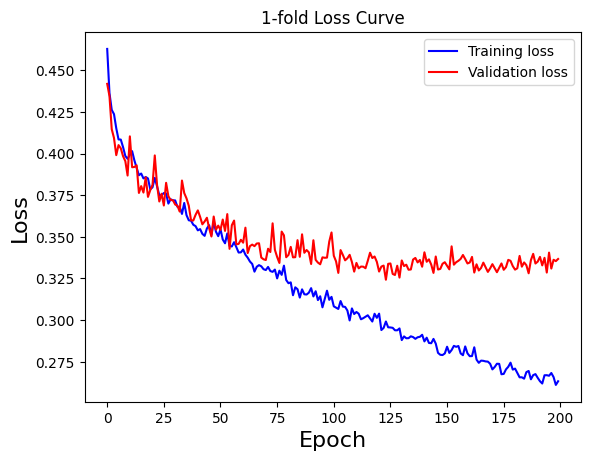

A Jupyter Widget

1/200 lr=0.00100 - loss:0.458, acc:42.203, val_loss:0.446, val_acc:44.579
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.445, acc:44.402, val_loss:0.452, val_acc:44.232
Best loss:0.446, Best accuracy:44.579, Best F1-score:0.440
3/200 lr=0.00100 - loss:0.429, acc:48.097, val_loss:0.439, val_acc:46.914
Best loss:0.446, Best accuracy:44.579, Best F1-score:0.440
4/200 lr=0.00100 - loss:0.424, acc:48.958, val_loss:0.435, val_acc:46.817
Best loss:0.439, Best accuracy:46.914, Best F1-score:0.459
5/200 lr=0.00100 - loss:0.424, acc:48.575, val_loss:0.424, val_acc:48.920
Best loss:0.439, Best accuracy:46.914, Best F1-score:0.459
6/200 lr=0.00100 - loss:0.410, acc:51.574, val_loss:0.415, val_acc:46.817
Best loss:0.424, Best accuracy:48.920, Best F1-score:0.475
7/200 lr=0.00100 - loss:0.412, acc:50.982, val_loss:0.414, val_acc:48.997
Best loss:0.424, Best accuracy:48.920, Best F1-score:0.475
8/200 lr=0.00100 - loss:0.403, acc:52.480, val_loss:0.402, val

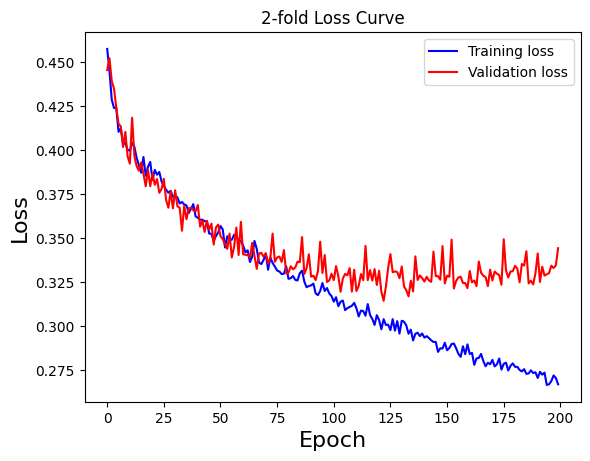

A Jupyter Widget

1/200 lr=0.00100 - loss:0.462, acc:40.209, val_loss:0.413, val_acc:49.961
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.435, acc:46.944, val_loss:0.406, val_acc:50.386
Best loss:0.413, Best accuracy:49.961, Best F1-score:0.488
3/200 lr=0.00100 - loss:0.427, acc:47.144, val_loss:0.393, val_acc:52.913
Best loss:0.406, Best accuracy:50.386, Best F1-score:0.484
4/200 lr=0.00100 - loss:0.421, acc:49.744, val_loss:0.387, val_acc:53.530
Best loss:0.393, Best accuracy:52.913, Best F1-score:0.521
5/200 lr=0.00100 - loss:0.423, acc:48.707, val_loss:0.422, val_acc:46.046
Best loss:0.387, Best accuracy:53.530, Best F1-score:0.526
6/200 lr=0.00100 - loss:0.426, acc:48.438, val_loss:0.396, val_acc:51.524
Best loss:0.387, Best accuracy:53.530, Best F1-score:0.526
7/200 lr=0.00100 - loss:0.414, acc:50.625, val_loss:0.390, val_acc:52.720
Best loss:0.387, Best accuracy:53.530, Best F1-score:0.526
8/200 lr=0.00100 - loss:0.412, acc:51.934, val_loss:0.389, val

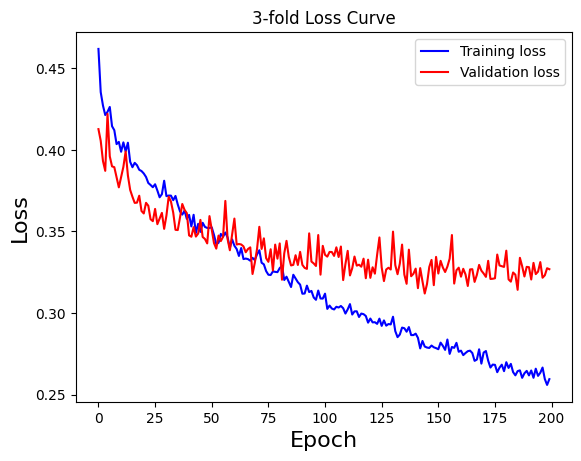

A Jupyter Widget

1/200 lr=0.00100 - loss:0.462, acc:41.066, val_loss:0.439, val_acc:47.184
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.438, acc:45.798, val_loss:0.428, val_acc:43.692
Best loss:0.439, Best accuracy:47.184, Best F1-score:0.456
3/200 lr=0.00100 - loss:0.438, acc:46.506, val_loss:0.426, val_acc:46.046
Best loss:0.439, Best accuracy:47.184, Best F1-score:0.456
4/200 lr=0.00100 - loss:0.436, acc:46.721, val_loss:0.408, val_acc:53.877
Best loss:0.439, Best accuracy:47.184, Best F1-score:0.456
5/200 lr=0.00100 - loss:0.426, acc:48.389, val_loss:0.398, val_acc:51.524
Best loss:0.408, Best accuracy:53.877, Best F1-score:0.524
6/200 lr=0.00100 - loss:0.422, acc:49.524, val_loss:0.391, val_acc:55.883
Best loss:0.408, Best accuracy:53.877, Best F1-score:0.524
7/200 lr=0.00100 - loss:0.413, acc:50.752, val_loss:0.385, val_acc:56.308
Best loss:0.391, Best accuracy:55.883, Best F1-score:0.551
8/200 lr=0.00100 - loss:0.415, acc:50.817, val_loss:0.379, val

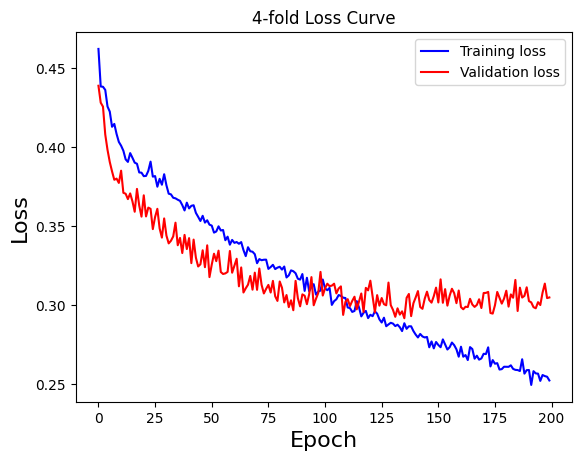

A Jupyter Widget

1/200 lr=0.00100 - loss:0.470, acc:38.795, val_loss:0.441, val_acc:47.164
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.439, acc:44.845, val_loss:0.420, val_acc:49.961
Best loss:0.441, Best accuracy:47.164, Best F1-score:0.450
3/200 lr=0.00100 - loss:0.430, acc:47.420, val_loss:0.409, val_acc:50.405
Best loss:0.420, Best accuracy:49.961, Best F1-score:0.496
4/200 lr=0.00100 - loss:0.423, acc:48.827, val_loss:0.406, val_acc:48.669
Best loss:0.409, Best accuracy:50.405, Best F1-score:0.498
5/200 lr=0.00100 - loss:0.416, acc:50.421, val_loss:0.397, val_acc:53.453
Best loss:0.409, Best accuracy:50.405, Best F1-score:0.498
6/200 lr=0.00100 - loss:0.412, acc:51.398, val_loss:0.403, val_acc:53.183
Best loss:0.397, Best accuracy:53.453, Best F1-score:0.521
7/200 lr=0.00100 - loss:0.408, acc:51.752, val_loss:0.394, val_acc:51.698
Best loss:0.397, Best accuracy:53.453, Best F1-score:0.521
8/200 lr=0.00100 - loss:0.406, acc:52.219, val_loss:0.384, val

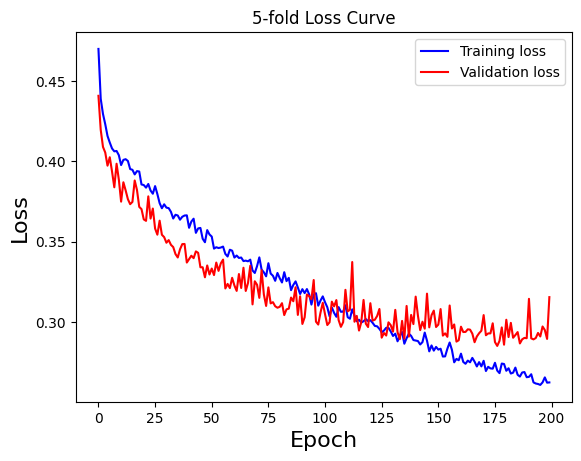

A Jupyter Widget

1/200 lr=0.00100 - loss:0.457, acc:42.650, val_loss:0.448, val_acc:45.004
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.436, acc:45.929, val_loss:0.437, val_acc:43.769
Best loss:0.448, Best accuracy:45.004, Best F1-score:0.447
3/200 lr=0.00100 - loss:0.424, acc:48.328, val_loss:0.442, val_acc:45.351
Best loss:0.448, Best accuracy:45.004, Best F1-score:0.447
4/200 lr=0.00100 - loss:0.421, acc:49.203, val_loss:0.422, val_acc:47.434
Best loss:0.442, Best accuracy:45.351, Best F1-score:0.438
5/200 lr=0.00100 - loss:0.409, acc:51.502, val_loss:0.412, val_acc:51.080
Best loss:0.422, Best accuracy:47.434, Best F1-score:0.476
6/200 lr=0.00100 - loss:0.411, acc:51.498, val_loss:0.410, val_acc:48.997
Best loss:0.412, Best accuracy:51.080, Best F1-score:0.509
7/200 lr=0.00100 - loss:0.408, acc:51.583, val_loss:0.405, val_acc:49.961
Best loss:0.412, Best accuracy:51.080, Best F1-score:0.509
8/200 lr=0.00100 - loss:0.407, acc:51.169, val_loss:0.403, val

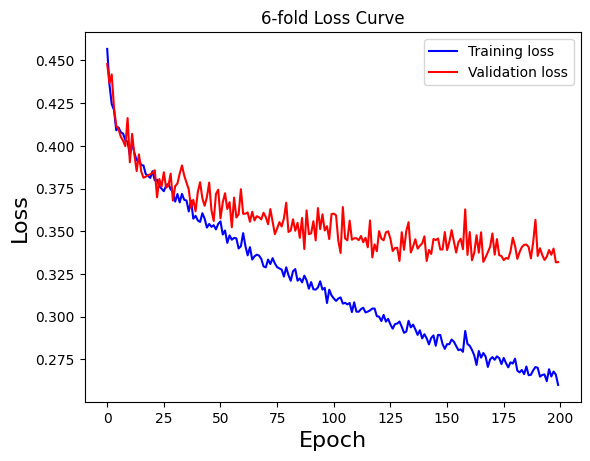

A Jupyter Widget

1/200 lr=0.00100 - loss:0.456, acc:42.163, val_loss:0.426, val_acc:48.380
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.432, acc:48.032, val_loss:0.421, val_acc:51.080
Best loss:0.426, Best accuracy:48.380, Best F1-score:0.477
3/200 lr=0.00100 - loss:0.427, acc:47.901, val_loss:0.408, val_acc:49.344
Best loss:0.421, Best accuracy:51.080, Best F1-score:0.509
4/200 lr=0.00100 - loss:0.418, acc:49.871, val_loss:0.397, val_acc:51.505
Best loss:0.421, Best accuracy:51.080, Best F1-score:0.509
5/200 lr=0.00100 - loss:0.415, acc:50.401, val_loss:0.381, val_acc:54.900
Best loss:0.397, Best accuracy:51.505, Best F1-score:0.510
6/200 lr=0.00100 - loss:0.410, acc:51.763, val_loss:0.378, val_acc:50.637
Best loss:0.381, Best accuracy:54.900, Best F1-score:0.553
7/200 lr=0.00100 - loss:0.409, acc:52.119, val_loss:0.368, val_acc:56.308
Best loss:0.381, Best accuracy:54.900, Best F1-score:0.553
8/200 lr=0.00100 - loss:0.404, acc:52.235, val_loss:0.376, val

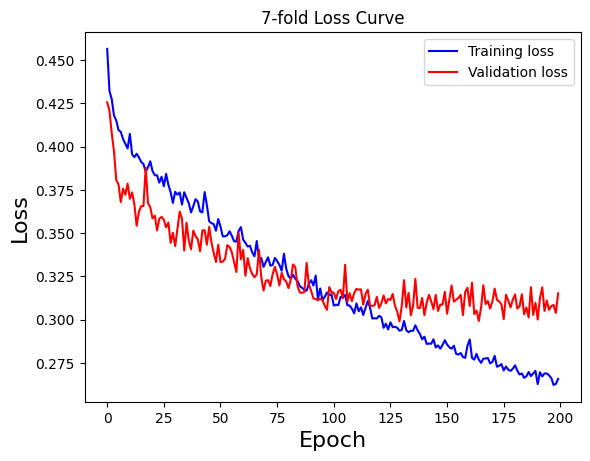

A Jupyter Widget

1/200 lr=0.00100 - loss:0.457, acc:43.165, val_loss:0.446, val_acc:46.065
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.441, acc:45.226, val_loss:0.434, val_acc:49.267
Best loss:0.446, Best accuracy:46.065, Best F1-score:0.438
3/200 lr=0.00100 - loss:0.430, acc:47.427, val_loss:0.424, val_acc:48.843
Best loss:0.434, Best accuracy:49.267, Best F1-score:0.480
4/200 lr=0.00100 - loss:0.420, acc:49.849, val_loss:0.432, val_acc:46.296
Best loss:0.434, Best accuracy:49.267, Best F1-score:0.480
5/200 lr=0.00100 - loss:0.414, acc:50.565, val_loss:0.401, val_acc:50.829
Best loss:0.434, Best accuracy:49.267, Best F1-score:0.480
6/200 lr=0.00100 - loss:0.411, acc:51.108, val_loss:0.394, val_acc:52.836
Best loss:0.401, Best accuracy:50.829, Best F1-score:0.508
7/200 lr=0.00100 - loss:0.416, acc:50.510, val_loss:0.400, val_acc:53.356
Best loss:0.394, Best accuracy:52.836, Best F1-score:0.522
8/200 lr=0.00100 - loss:0.406, acc:52.549, val_loss:0.384, val

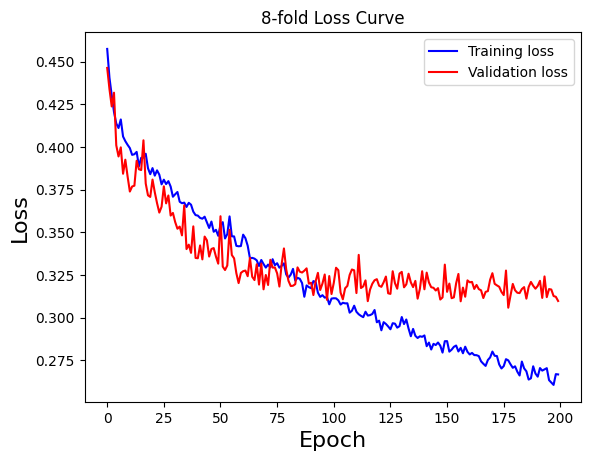

A Jupyter Widget

1/200 lr=0.00100 - loss:0.465, acc:40.077, val_loss:0.427, val_acc:47.357
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.442, acc:45.052, val_loss:0.417, val_acc:49.441
Best loss:0.427, Best accuracy:47.357, Best F1-score:0.461
3/200 lr=0.00100 - loss:0.436, acc:46.652, val_loss:0.422, val_acc:46.200
Best loss:0.417, Best accuracy:49.441, Best F1-score:0.486
4/200 lr=0.00100 - loss:0.422, acc:50.309, val_loss:0.407, val_acc:50.482
Best loss:0.417, Best accuracy:49.441, Best F1-score:0.486
5/200 lr=0.00100 - loss:0.420, acc:49.230, val_loss:0.399, val_acc:53.241
Best loss:0.407, Best accuracy:50.482, Best F1-score:0.466
6/200 lr=0.00100 - loss:0.415, acc:50.321, val_loss:0.390, val_acc:54.302
Best loss:0.399, Best accuracy:53.241, Best F1-score:0.526
7/200 lr=0.00100 - loss:0.409, acc:51.988, val_loss:0.398, val_acc:54.051
Best loss:0.390, Best accuracy:54.302, Best F1-score:0.530
8/200 lr=0.00100 - loss:0.407, acc:51.988, val_loss:0.409, val

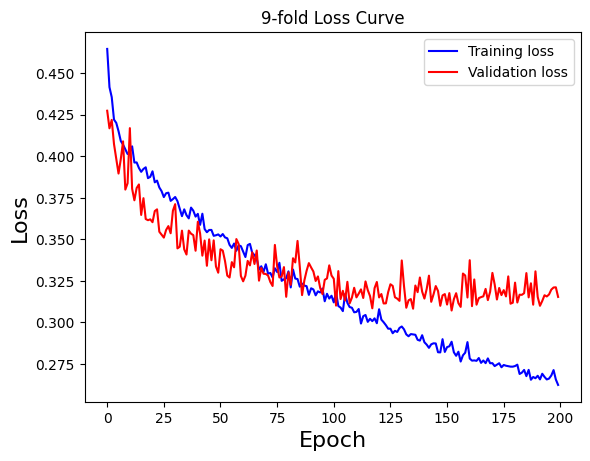

A Jupyter Widget

1/200 lr=0.00100 - loss:0.460, acc:41.457, val_loss:0.434, val_acc:45.004
Best loss:4144959.000, Best accuracy:-1.000, Best F1-score:-1.000
2/200 lr=0.00100 - loss:0.436, acc:46.744, val_loss:0.414, val_acc:48.225
Best loss:0.434, Best accuracy:45.004, Best F1-score:0.450
3/200 lr=0.00100 - loss:0.429, acc:47.665, val_loss:0.406, val_acc:47.878
Best loss:0.414, Best accuracy:48.225, Best F1-score:0.470
4/200 lr=0.00100 - loss:0.421, acc:49.780, val_loss:0.399, val_acc:52.045
Best loss:0.414, Best accuracy:48.225, Best F1-score:0.470
5/200 lr=0.00100 - loss:0.414, acc:50.512, val_loss:0.386, val_acc:53.241
Best loss:0.399, Best accuracy:52.045, Best F1-score:0.512
6/200 lr=0.00100 - loss:0.406, acc:52.313, val_loss:0.385, val_acc:53.704
Best loss:0.386, Best accuracy:53.241, Best F1-score:0.532
7/200 lr=0.00100 - loss:0.407, acc:52.655, val_loss:0.376, val_acc:55.093
Best loss:0.385, Best accuracy:53.704, Best F1-score:0.536
8/200 lr=0.00100 - loss:0.406, acc:53.352, val_loss:0.368, val

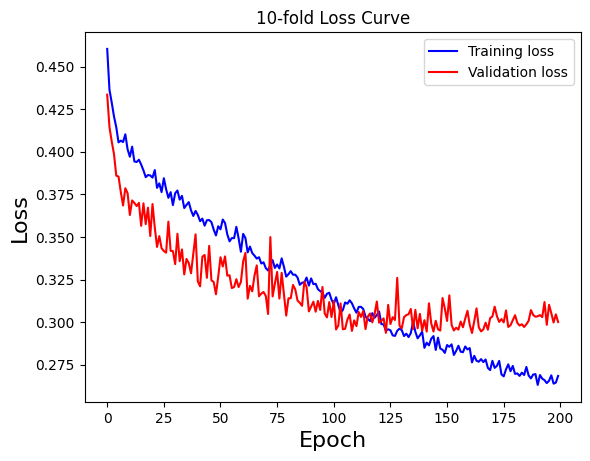

In [12]:
import tensorflow_addons as tfa
from keras.models import load_model

emotions_groundtruth_list = np.array([])
predicted_emotions_list = np.array([])

fold_acc = []

kfold = KFold(n_splits=k, shuffle=True, random_state=98)

for i, (train, test) in tqdm(enumerate(kfold.split(x, y)), desc=f'Training {k}-Fold.....'):
    save_path = f'Models/{DATA_PATH}'
    os.makedirs(save_path, exist_ok=True)
    h5_path = f'{save_path}/{model_name}_{i}-fold_.h5'
    
    x_train, y_train = x[train], y[train]
    y_train = smooth_labels(y[train], 0.1)
    
    x_test, y_test = x[test], y[test]
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    
    shape = x_train.shape[1:]
    
    optimizer = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    
    model = Model(len(CLASS_LABELS))
    
    best_test_loss = 0x3f3f3f
    best_test_acc = -1
    best_test_f1 = -1
    
    epoch_losses = []
    valid_losses = []
    
    batch_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(2022).batch(BATCH)
    batch_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH)
    for epoch in tqdm(range(EPOCHS), desc=f'Fold-{i+1}'):

        train_loss, train_acc = [], []
        for features, labels in batch_train:
            loss, acc = train_step(model, optimizer, features, labels)
            train_loss.append(loss)
            train_acc.append(acc)
            
        test_loss, test_acc, f1s = [], [], []
        for features, labels in batch_test:
            loss, acc, pred = test_step(model, features, labels)
            test_loss.append(loss)
            test_acc.append(acc)
            
            f1_metric = tfa.metrics.F1Score(num_classes=len(CLASS_LABELS), average='weighted')
            f1_metric.update_state(labels, pred)
            f1 = f1_metric.result().numpy()
            f1s.append(f1)
            
        
        epoch_loss = sum(train_loss)/len(train_loss)
        epoch_acc = sum(train_acc)/len(train_acc)
        val_loss = sum(test_loss)/len(test_loss)
        val_acc = sum(test_acc)/len(test_acc)
        f1_score = sum(f1s)/len(f1s)
        
        epoch_losses.append(epoch_loss)
        valid_losses.append(val_loss)
        
        cur_lr = K.eval(optimizer.lr)
        print(f'{epoch+1}/{EPOCHS} lr={cur_lr:.5f} - loss:{epoch_loss:.3f}, acc:{epoch_acc:.3f}, val_loss:{val_loss:.3f}, val_acc:{val_acc:.3f}')
        print(f'Best loss:{best_test_loss:.3f}, Best accuracy:{best_test_acc:.3f}, Best F1-score:{best_test_f1:.3f}')
        
        set_lr = scheduler(epoch, K.eval(optimizer.lr))
        K.set_value(optimizer.learning_rate, set_lr)
        
        if best_test_acc < val_acc:
            best_test_acc = val_acc
            best_test_loss = val_loss
            best_test_f1 = f1_score
            model.save_weights(h5_path)
            
            
    model = Model(len(CLASS_LABELS))
    model.build(input_shape=x_train.shape)
    model.load_weights(h5_path)
    
    for features, labels in batch_test:
        best_pred = model(features, training=False)
        emotions_groundtruth_list = np.append(emotions_groundtruth_list, np.argmax(labels, axis=1))
        predicted_emotions_list = np.append(predicted_emotions_list, np.argmax(best_pred, axis=1))
    
    
    print(f'[*] Done - acc:{best_test_acc:.3f}')
    
    plt.title(f'{i+1}-fold Loss Curve')
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.plot(epoch_losses[:],'b')
    plt.plot(valid_losses[:],'r')
    plt.legend(['Training loss','Validation loss'])

    
    save_fig_path = f'Fig/{DATA_PATH}/training/{model_name}'
    os.makedirs(save_fig_path, exist_ok=True)
    plt.savefig(f'{save_fig_path}/{i+1}-fold.PNG')
    
    plt.show()
    
    fold_acc.append(best_test_acc)

In [13]:
end()

In [14]:
print(f'max:{max(fold_acc)}, min:{min(fold_acc)}, average:{sum(fold_acc)/len(fold_acc)}')

max:68.82716053062015, min:63.61882719728682, average:66.4976852469974


In [15]:
import warnings
warnings.filterwarnings('always')

Report = classification_report(emotions_groundtruth_list, predicted_emotions_list)

os.makedirs(f'Results/{DATA_PATH}', exist_ok=True)
report_path = f'Results/{DATA_PATH}/{model_name}_{k}-fold_nomalize.txt'

with open(report_path, "w") as f:
    f.write(Report)

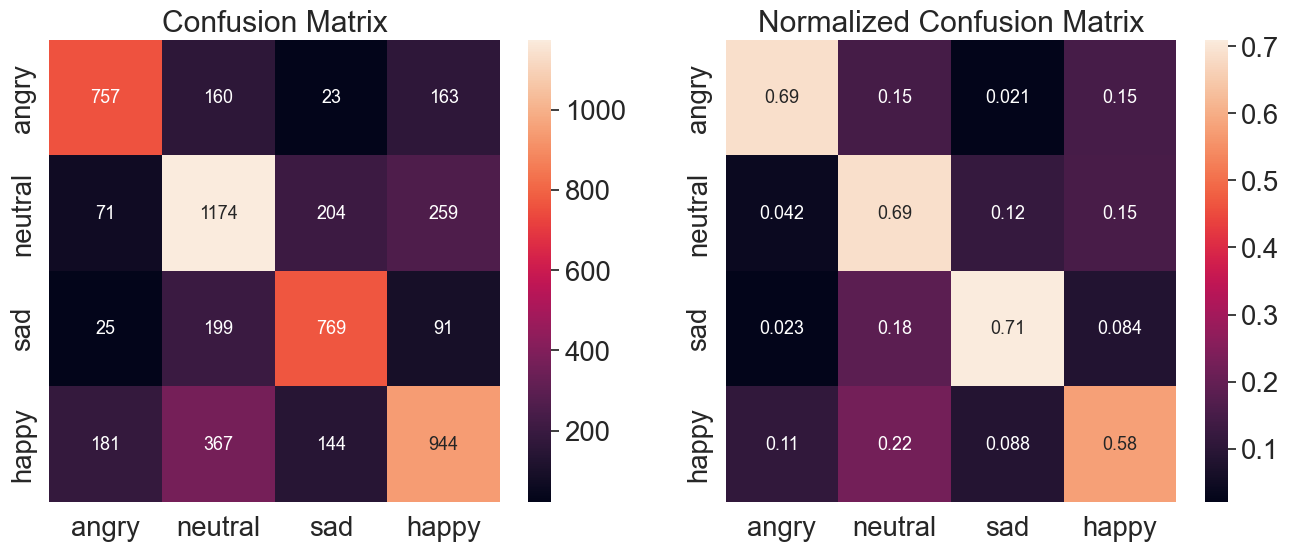

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

emotion_names = CLASS_LABELS


# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list)
conf_matrix_norm = confusion_matrix(emotions_groundtruth_list, predicted_emotions_list,normalize='true')

# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_names, columns=emotion_names)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_names, columns=emotion_names)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 13}, fmt='g') #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font
plt.savefig(f'Results/{DATA_PATH}/{model_name}_{feature_name}_{k}-fold_confmatrix.pdf')
plt.show()

In [17]:
get_metric_calc(conf_matrix)

WAR(Weighted Average Recall)   : 66.50%
UAR(Unweighted Average Recall) : 66.50%
